# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
# !mkdir cifar10
# !curl -o cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# !tar -xvzf cifar-10-python.tar.gz -C cifar10

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  162M  100  162M    0     0  2498k      0  0:01:06  0:01:06 --:--:-- 4075k      0  0:01:18  0:00:22  0:00:56 2181k
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
import os
os.environ['PYLEARN2_DATA_PATH'] = '/home/ubuntu/mipt-ml/hw6'

from pylearn2.scripts.datasets import make_cifar10_gcn_whitened
make_cifar10_gcn_whitened.main()

Loading CIFAR-10 train dataset...
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_1
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_2
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_3
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_4
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_5
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/test_batch
Preparing output directory...
Learning the preprocessor and           preprocessing the unsupervised train data...


/home/ubuntu/pylearn2/pylearn2/datasets/preprocessing.py:1202: UserWarning: This ZCA preprocessor class is known to yield very different results on different platforms. If you plan to conduct experiments with this preprocessing on multiple machines, it is probably a good idea to do the preprocessing on a single machine and copy the preprocessed datasets to the others, rather than preprocessing the data independently in each location.
  warnings.warn("This ZCA preprocessor class is known to yield very "


computing zca of a (50000, 3072) matrix
cov estimate took 2.518582820892334 seconds
eigh() took 4.870057106018066 seconds
Saving the unsupervised data
Loading the test data
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_1
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_2
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_3
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_4
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/data_batch_5
loading file /home/ubuntu/mipt-ml/hw6/cifar10/cifar-10-batches-py/test_batch
Preprocessing the test data
Saving the test data


In [50]:
from cifar import load_CIFAR10
import _pickle as pickle
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

# cifar10_dir = '../data/cifar10/cifar-10-batches-py'
cifar10_dir = './cifar10/cifar-10-batches-py'
preprocessed = './cifar10/pylearn2_gcn_whitened'
# X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

with open(preprocessed + '/train.pkl', 'rb') as f:
    module = pickle.load(f, encoding="latin1")
    X_train, y_train = module.get_data()

with open(preprocessed + '/test.pkl', 'rb') as f:
    module = pickle.load(f, encoding="latin1")
    X_test, y_test = module.get_data()

X_train = X_train.reshape(X_train.shape[0], 3, 32, 32).astype("float")
y_train = y_train.T.reshape(y_train.shape[0])

X_test = X_test.reshape(X_test.shape[0], 3, 32, 32).astype("float")
y_test = y_test.T.reshape(y_test.shape[0])

In [52]:
y_test.shape

(10000,)

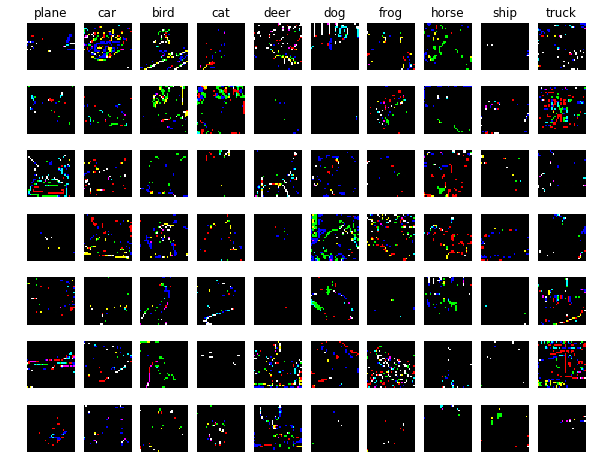

In [38]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

Значительно большая глубина, прокидывание результатов слоев, batch normalisation, ... 

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

Они могут не учиться из-за большого learning rate или batch size. Из проблем в архитектуре - затухание градиентов, первые слои практически не учатся в глубокой сети

**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

Data augmentation. Добавляем различный шум, поворачивает на малые углы, etc. Правда, в таком случае может быть переобучение.

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

Преобразовать аудио в гистограмму, в свертке одно из измерений должно полностью покрывать ширину гистограммы.

In [39]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X", dtype='float32')
target_y = T.vector("target Y integer", dtype='int32')

### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [66]:
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers.dnn import batch_norm_dnn as batch_norm

def get_residual(in_l, n):
    stack1 = batch_norm(ConvLayer(in_l, n, 3, pad='same')) # сверточный слой
    stack2 = batch_norm(ConvLayer(stack1, n, 3, pad='same')) # сверточный слой
    layer = batch_norm(lasagne.layers.NonlinearityLayer(lasagne.layers.ElemwiseSumLayer([stack1, stack2])))
    
    return layer

def get_proto_layer(in_l, n, num_residual=5):
    for i in range(num_residual):
        in_l = get_residual(in_l, n)
    
    return in_l

In [67]:
from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPoolLayer

net = lasagne.layers.InputLayer(shape=(None, 3, 32, 32), input_var=input_X)

n0 = 32

l1 = get_proto_layer(net, n0)
l2 = get_residual(l1, n0 * 2)

net = MaxPoolLayer(l2, pool_size=2)

l3 = get_residual(net, n0 * 4)

net = MaxPoolLayer(l3, pool_size=2)

l4 = get_residual(net, n0 * 8)

net = MaxPoolLayer(l4, pool_size=2)

net = batch_norm(lasagne.layers.DenseLayer(net, num_units=512))
net = lasagne.layers.DropoutLayer(net, 0.5)
net = lasagne.layers.DenseLayer(net, num_units=10, nonlinearity=softmax)

print("l1", l1.output_shape)
print("l2", l2.output_shape)
print("l3", l3.output_shape)
print("l4", l4.output_shape)
print("number of parameters in model: {}".format(lasagne.layers.count_params(net, trainable=True)))

l1 (None, 32, 32, 32)
l2 (None, 64, 32, 32)
l3 (None, 128, 16, 16)
l4 (None, 256, 8, 8)
number of parameters in model: 3351978


In [42]:
lasagne.layers.ElemwiseSumLayer?

In [68]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print(all_weights)

[W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, beta, gamma, beta, gamma, W, beta, gamma, W, b]


In [73]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()

all_layers = lasagne.layers.get_all_layers(net)
l2_penalty = lasagne.regularization.regularize_layer_params(all_layers, lasagne.regularization.l2) * 0.0005
loss = loss + l2_penalty

lr = 0.001
sh_lr = theano.shared(lasagne.utils.floatX(lr))

updates = lasagne.updates.adam(loss, all_weights, learning_rate=sh_lr)

In [74]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates=updates, 
                            allow_input_downcast=True)
accuracy_fun = theano.function([input_X, target_y], accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [91]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [71]:
# ############################# Batch iterator ###############################
# from https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py

def iterate_minibatches(inputs, targets, batchsize, shuffle=False, augment=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if augment:
            # as in paper : 
            # pad feature arrays with 4 pixels on each side
            # and do random cropping of 32x32
            padded = np.pad(inputs[excerpt], ((0, 0), (0, 0), (4, 4), (4, 4)), mode='constant')
            random_cropped = np.zeros(inputs[excerpt].shape, dtype=np.float32)
            crops = np.random.randint(0, 9, size=(batchsize, 2))
            for r in range(batchsize):
                random_cropped[r, :, :, :] = padded[r, :, crops[r, 0]:(crops[r, 0] + 32), crops[r, 1]:(crops[r, 1] + 32)]
            inp_exc = random_cropped
        else:
            inp_exc = inputs[excerpt]

        yield inp_exc, targets[excerpt]

# Процесс обучения

In [62]:
new_lr = sh_lr.get_value() * 4
print("New learning rate: {:.9f}".format(new_lr))
sh_lr.set_value(lasagne.utils.floatX(new_lr))

New learning rate: 0.000000859


In [76]:
import time

num_epochs = 32 # количество проходов по данным

batch_size = 50 # размер мини-батча
coef = 0.9

X_val, y_val = X_test, y_test

for epoch in range(2, num_epochs):
    if epoch >= 30:
        coef = 0.7
    if epoch >= 40:
        coef = 0.5
    if epoch > 3:
        new_lr = sh_lr.get_value() * coef
        print("New learning rate: {:.9f}".format(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))

    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True, augment=True):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))
    
    with open('log', 'a') as log:
        print("Epoch {} of {} took {:.3f}s".format(epoch, num_epochs, time.time() - start_time), file=log)
        print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches), file=log)
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100), file=log)
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100), file=log)

Epoch 2 of 32 took 154.859s
  training loss (in-iteration):		1.605092
  train accuracy:		68.19 %
  validation accuracy:		73.17 %
Epoch 3 of 32 took 155.036s
  training loss (in-iteration):		1.425202
  train accuracy:		72.49 %
  validation accuracy:		75.28 %
New learning rate: 0.000900000
Epoch 4 of 32 took 154.888s
  training loss (in-iteration):		1.268936
  train accuracy:		75.92 %
  validation accuracy:		77.14 %
New learning rate: 0.000810000
Epoch 5 of 32 took 154.693s
  training loss (in-iteration):		1.157602
  train accuracy:		78.52 %
  validation accuracy:		79.33 %
New learning rate: 0.000729000
Epoch 6 of 32 took 155.022s
  training loss (in-iteration):		1.068059
  train accuracy:		80.35 %
  validation accuracy:		80.69 %
New learning rate: 0.000656100
Epoch 7 of 32 took 154.830s
  training loss (in-iteration):		0.988037
  train accuracy:		81.90 %
  validation accuracy:		81.55 %
New learning rate: 0.000590490
Epoch 8 of 32 took 154.710s
  training loss (in-iteration):		0.926384
 

In [77]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print("Achievement unlocked: колдун 80 уровня")
else:
    print("Нужно больше магии!")

Final results:
  test accuracy:		87.11 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 